## Using RNN for feature extraction from audio input

The internet suggest we should use RNN on spectogram (as omer did with cnn) by considering each column of the spectogram as the current input (in the time dimension) and then using the recurrent network.

Working with the raw audio is not so simple as I originally thought because even if I would use LSTM (which can handle longer sequences than simple RNN), we are talking about sequences of length of ~1e-6 and I think we won't be able to train this well naively. It is possible to do Truncated backpropagation through time (TBPTT) and if time would allow us, we will try that as well but because using spectogram was suggested by the internet, we will go with it.

### Data processing:

In [1]:
import sys; sys.path.append('..')

#### Playing with the data:

In [2]:
from pychorus.helpers import find_and_output_chorus
import matplotlib.pyplot as plt
from IPython.display import Audio
import numpy as np
import torchaudio
import librosa

For each song, we will focus only on the chorus. The idea behind this is both in term of performance and in term of computations. In terms of performance, the chorus contains the whole message of the song in just a few lines and also it will be the most powerful, highest energy, loudest, catchiest, and most memorable part of any song. Thus, it make sense that most tiktokers will choose this part for their video. In addition, in term of computation, working on shorter audio file (only the chorus compared to the whole song) / smaller spectogram will require less computations.

In order to do so, we will use pychorus library.

In [6]:
x, sr = librosa.load('../data/audio/0e3CM2Fm4cpDtxjzYkdLAr.mp3')
start = int(find_and_output_chorus(input_file='../data/audio/0e3CM2Fm4cpDtxjzYkdLAr.mp3', output_file=None, clip_length=30))

Best chorus found at 1 min 20.04 sec


And now let's plot the predicted chorus and hear it:

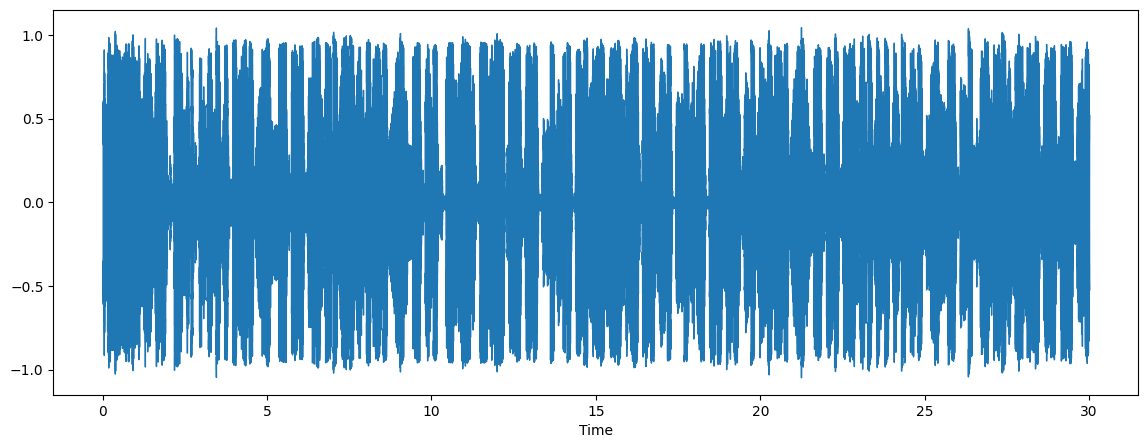

In [4]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x[start*sr:(start+30)*sr], sr=sr)

In [5]:
chorus = x[start*sr:(start+30)*sr]
Audio(data = chorus, rate=sr)

and it really sounds like the real chorus (cut in the middle because I limit the duration to be 30 seconds).

Let's try to plot the spectogram of the chorus. 

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

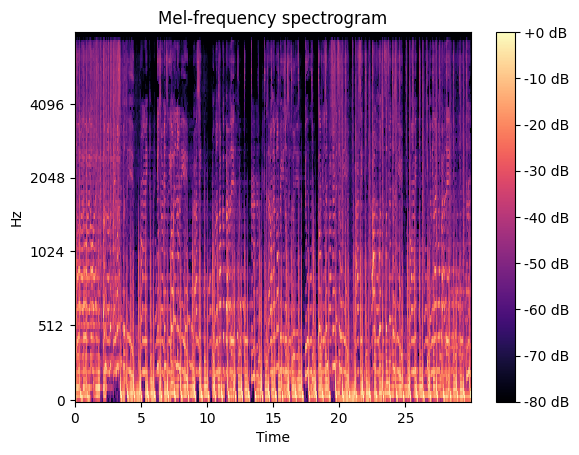

In [7]:
S = librosa.feature.melspectrogram(y=chorus, sr=sr) #n_fft=2048, hop_length=512 by default
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max(S))
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

It seems that the high frequencies as high dB, which might indicate more rhythmic song (in addition to the previous plot where we can see rapid changes in the signal). This in turn can indicate the virality of the song but we will let the model decide it.

Let's create the pipeline of the preprocessing.

#### preprocessing pipeline:

The following is the basic pipeline:

                Raw audio -> calculate mean of channels -> extract chorus from audio -> create spectorgram from audio -> convert spectogram from amplitude to dB

In [2]:
from torch.utils.data import random_split
from src.RNN_utils.dataset import SoundDS
import pandas as pd
import torch

In [3]:
myds = SoundDS(pd.read_csv('../data/metadata.csv'), '../data/audio/', n_mel=64)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=1, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=1, shuffle=False)

In [4]:
inputs, classes = next(iter(train_dl))

In [6]:
inputs.shape

torch.Size([1, 1, 64, 3308])